A brute force approach to calculating simplicial cohomology

In [1]:
import networkx as nx
import numpy as np

In [2]:
from itertools import product
def build_1_skeleton_from_simplices(simplices):
    edges = []
    for simplex in simplices:
        for s, t in product(simplex, simplex):
            if s == t:
                continue
            edges.append((s, t))
    return nx.Graph(edges)

In [3]:
class CyclicGroupElement:
    
    def __init__(self, value, n):
        self.value = value % n
        self.n = n
    
    def __eq__(self, other):
        if isinstance(other, int):
            return self.value == other % self.n
        elif isinstance(other, CyclicGroupElement):
            return self.n == other.n and self.value == other.value
        return False
    
    def __ne__(self, other):
        return not self == other
        
    def __neg__(self):
        return CyclicGroupElement(self.n - self.value, self.n)
    
    def __add__(self, other):
        assert self.n == other.n
        return CyclicGroupElement(self.value + other.value, self.n)
    
    def __sub__(self, other):
        assert self.n == other.n
        return CyclicGroupElement(self.value + (-other).value, self.n)
    
    def __mul__(self, other):
        if isinstance(other, int):
            return CyclicGroupElement(self.value * other, self.n)
        assert self.n == other.n
        return CyclicGroupElement(self.value * other.value, self.n)
    
    def __rmul__(self, other):
        return self * other
    
    def __str__(self):
        return f"{self.value}"
    
    def __repr__(self):
        return f"{self.value} in Z/{self.n}Z"
    
class CyclicGroup:
    
    def __init__(self, n):
        self.n = n
        
    def __call__(self, value):
        return CyclicGroupElement(value, self.n)
    
    def __iter__(self):
        yield from range(self.n)
    
z2 = CyclicGroup(2)
print(z2(3) + z2(1))
print(-CyclicGroup(5)(2))

0
3


In [5]:
from dataclasses import dataclass
from typing import Tuple, Iterable

class Chain:
    
    def __init__(self, scaled_simplices: Iterable):
        self.simplices = list(scaled_simplices)
        self.dim = self.simplices[0].dim
        for simplex in self.simplices:
            assert(simplex.dim == self.dim)
        
    def __repr__(self):
        result = ""
        for simplex in self.simplices:
            result += f"+{simplex.scalar}{simplex.simplex}"
        return result
    
    def __iter__(self):
        yield from self.simplices

@dataclass
class ScaledSimplex:
    
    simplex: Tuple[int] 
    scalar: int = 1

        
    def boundary(self) -> Chain:
        faces = []
        for i in range(len(self.simplex)):
            face_scalar = self.scalar
            if i%2 == 1:
                face_scalar = -face_scalar
            
            faces.append(ScaledSimplex(scalar=face_scalar, simplex=self.simplex[:i] + self.simplex[i+1:]))
        return Chain(faces)
    
    @property
    def dim(self):
        return len(self.simplex) - 1

z3 = CyclicGroup(3)
simplex = ScaledSimplex(scalar=1, simplex=(1,2,3))
print(simplex)
print(simplex.boundary())

ScaledSimplex(simplex=(1, 2, 3), scalar=1)
+1(2, 3)+-1(1, 3)+1(1, 2)


In [45]:
class Cochain:
    
    def __init__(self, simplex_map, simplicial_complex, hom_field):
        # simplices not present in map are presumed to be 0
        self.dimension = len(list(simplex_map.keys())[0])-1
        self.field = hom_field
        self.simplex_map = simplex_map
        for s in simplicial_complex[self.dimension]:
            if s not in self.simplex_map:
                self.simplex_map[s] = self.field(0)
        self.compact_form = f"{self.dimension}: " + ",".join(str(simplex_map.get(s, hom_field(0)).value) for s in simplicial_complex[self.dimension])
        self.simplicial_complex = simplicial_complex
        
    def coboundary(self):
        coboundary_map = {}
        if self.dimension+1 == len(self.simplicial_complex):
            return Cochain({tuple([0]*(self.dimension+1)): self.field(0)}, self.simplicial_complex, self.field)
        for simplex in self.simplicial_complex[self.dimension+1]:
            coboundary_map[simplex] = self.apply(ScaledSimplex(simplex).boundary())
        return Cochain(coboundary_map, self.simplicial_complex, self.field)
    
    def apply(self, chain):
        assert chain.dim == self.dimension
        value = self.field(0)
        for simplex in chain:
            value += simplex.scalar * self.simplex_map.get(simplex.simplex, self.field(0))
        return value
        
    def is_cocycle(self):
        # a cocycle is a cochain that behaves as the zero map when composed with the boundary
        if self.dimension+1 == len(self.simplicial_complex):
            return True
        cofaces = self.simplicial_complex[self.dimension+1]
        for coface in cofaces:
            coface_boundary = ScaledSimplex(coface).boundary()
            if self.apply(coface_boundary) != 0:
                return False
        return True
    
    def __eq__(self, other):
        if not isinstance(other, Cochain):
            return False
        if self.dimension != other.dimension:
            return False
        if self.field.n != other.field.n:
            return False
        for simplex in self.simplex_map:
            if simplex not in other.simplex_map or other.simplex_map[simplex] != self.simplex_map[simplex]:
                return False
        for simplex in other.simplex_map:
            if simplex not in self.simplex_map and other.simplex_map[simplex] != self.field(0):
                return False
        return True
    
    def is_homologous_to(self, other, coboundaries):
        for scalar in range(1,self.field.n):
            if scalar*self - other in coboundaries:
                return True
        return False
            
    def __rmul__(self, scalar):
        new_map = {s: scalar*v for s, v in self.simplex_map.items()}
        return Cochain(new_map, self.simplicial_complex, self.field)
    
        
    def __add__(self, other):
        all_simplices = set(self.simplex_map.keys()) | set(other.simplex_map.keys())
        new_map = {}
        for simplex in all_simplices:
            our_value = self.simplex_map.get(simplex, self.field(0))
            other_value = other.simplex_map.get(simplex, other.field(0))
            new_map[simplex] = our_value + other_value
        return Cochain(new_map, self.simplicial_complex, self.field)
    
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        new_map = {s: -e for s, e in self.simplex_map.items()}
        return Cochain(new_map, self.simplicial_complex, self.field)
    
    def __hash__(self):
        return hash(self.compact_form)
    
    def __repr__(self):
        return self.compact_form
    
    

def is_coboundary(cochain, coboundaries):
    # a coboundary is a cochain that is itself the coboundary of a lower-dimensional cochain
    return any(cochain == coboundary for coboundary in coboundaries)

In [46]:
def faces(simplices):
    faces = []
    for s in simplices:
        faces.extend(s[:i] + s[i+1:] for i in range(len(s)))
    return list(set(faces))

In [47]:
from tqdm import tqdm
def enumerate_cochains(simplices, simplicial_complex, field):
    field_values = [field(i) for i in range(field.n)]
    for assignments in tqdm(product(*([field_values]*len(simplices)))):
        mapping = {s: a for s, a in zip(simplices, assignments)}
        yield Cochain(mapping, simplicial_complex, field)

In [48]:
class CochainGroup:
    
    def __init__(self, cochains, coboundaries):
        self.dimension = cochains[0].dimension
        self.simplicial_complex = cochains[0].simplicial_complex
        self.field = cochains[0].field
        self.zero = Cochain({self.simplicial_complex[self.dimension][0]: self.field(0)}, self.simplicial_complex, self.field)
        self.coboundaries = set(coboundaries)
        self.coboundaries.add(self.zero)
        self.cocycles = set(c for c in cochains if c.is_cocycle())
        self.cochains = set(cochains)
        self.cocycle_generators = self.find_cocycle_generators()
        self.build_cohomology()
        
    def find_cocycle_generators(self):
        # Possibly a gaussian elim approach is better?
        # But this caches a lot of stuff
        generators = None
        generated = set()
        ordered_cocycles = sorted(self.cocycles, key=lambda x: sum(v.value for v in x.simplex_map.values()))
        for cocycle in ordered_cocycles:
            if generators is None:
                generators = [cocycle]
                generated = {s*cocycle for s in self.field}
                continue
            
            if cocycle in generated:
                continue
            
            generators.append(cocycle)
            new_elements = {s*cocycle for s in self.field}
            linear_combinations = set()
            for element in new_elements:
                for g in generated:
                    linear_combinations.add(element+g)
            generated |= new_elements | linear_combinations

        return generators
    
    def retrieve_homologous_cocycles(self, cocycle):
        homologous = {cocycle+b for b in self.coboundaries}
        return homologous
        
    def build_cohomology(self):
        self.cohomology_groups = {self.zero: {self.zero}}
        
        claimed_coboundaries = set()
        
        for generator in self.cocycle_generators:
            if generator in claimed_coboundaries:
                continue
            for representative, group in self.cohomology_groups.items():
                if generator.is_homologous_to(representative, self.coboundaries):
                    group.add(generator)
                    break
            else:
                self.cohomology_groups[generator] = {generator}
                new_claims = self.retrieve_homologous_cocycles(generator)
                for claim in new_claims:
                    claimed_coboundaries |= {claim+co for co in claimed_coboundaries}
                claimed_coboundaries |=  new_claims
                

class CochainComplex:
    
    def __init__(self, simplicial_complex, field):
        self.simplicial_complex = simplicial_complex
        self.field = field
        self.cochain_groups = self.build_cochains()
        
    def build_cochains(self):
        cochain_groups = []
        coboundaries = []
        for index, simplices in enumerate(self.simplicial_complex):
            cochains = list(enumerate_cochains(simplices, self.simplicial_complex, self.field))
            cochain_groups.append(CochainGroup(cochains, coboundaries))
            coboundaries = [c.coboundary() for c in cochains]
        return cochain_groups
        

In [72]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

class SimplicialComplex:
    
    def __init__(self, simplices, vertex_pos, hom_field):
        for dimension in simplices:
            for simplex in dimension:
                for first, second in zip(simplex, simplex[1:]):
                    if first >= second:
                        raise Exception("bad simplex detected!", simplex)
                        
        self.simplices = simplices
        self.vertex_pos = vertex_pos
        self.field = hom_field
        self.cochain_complex = CochainComplex(simplices, hom_field)
        self.graph = nx.Graph(simplices[1])
        
    def draw_cohomology_generators(self, num_examples=3):
        num_rows = len(self.cochain_complex.cochain_groups[1].cohomology_groups)
        fig, axs = plt.subplots(num_rows, num_examples+1)
        fig.set_size_inches((4*(num_examples+1), 4*num_rows))

        for row, (generator, cocycles) in enumerate(self.cochain_complex.cochain_groups[1].cohomology_groups.items()):
            if num_rows > 1:
                ax_row = axs[row]
            else:
                ax_row = axs
            print(generator)
            zero_class = generator == self.cochain_complex.cochain_groups[1].zero
            homologous = self.cochain_complex.cochain_groups[1].retrieve_homologous_cocycles(generator)
            self.draw_cochain(generator, ax_row[0])
            if row == 0:
                ax_row[0].set_title("Homology Generators")
            if len(homologous) < num_examples:
                to_plot = list(range(len(homologous)))
            else:
                to_plot = set(np.random.choice(list(range(len(homologous))), size=num_examples, replace=False))
            plotted = 0
            for i, cocycle in enumerate(homologous):
                if i in to_plot:
                    print("  ", cocycle)
                    self.draw_cochain(cocycle, ax_row[plotted+1])
                    if row == 0:
                        ax_row[plotted+1].set_title("Example Homologous Coboundary")
                    plotted += 1
        plt.show()
            

    def draw_cochain(self, cochain, ax, vertex_colors=None):
        cmap = ListedColormap(["0.9", "b", "r"])
        edge_colors = []
        for edge in self.graph.edges:
            try:
                value = cochain.simplex_map[edge].value
            except KeyError:
                value = 0
            edge_colors.append(value)
        nx.draw(self.graph, pos=self.vertex_pos, with_labels=True, edge_color=edge_colors, edge_cmap=cmap, ax=ax)


81it [00:00, 61313.59it/s]
243it [00:00, 84729.89it/s]
9it [00:00, 72593.72it/s]

1: 0,0,0,0,0
   1: 0,2,2,0,1
   1: 0,0,0,0,0
   1: 2,2,0,1,1


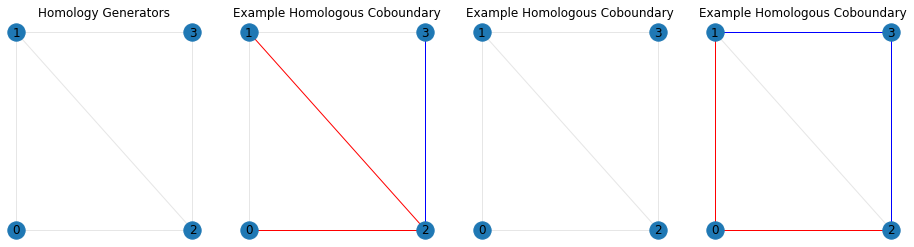

In [73]:
square_points = np.array([
    [0, 0],
    [0, 4],
    [4, 0],
    [4, 4]
])

square_edges = [
    (0, 1),
    (0, 2),
    (1, 2),
    (1, 3),
    (2, 3)
]

simplices = [
    (0, 1, 2),
    (1, 2, 3)
]
cplx = SimplicialComplex([faces(square_edges), square_edges, simplices], square_points, CyclicGroup(3))
cplx.draw_cohomology_generators()

256it [00:00, 36955.49it/s]
65536it [00:01, 57479.55it/s]
256it [00:00, 121670.46it/s]


1: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
   1: 0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,1
   1: 1,1,1,1,0,1,0,1,1,1,0,0,0,1,0,1
   1: 1,0,0,1,0,1,0,1,1,1,0,0,1,0,1,0
1: 0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
   1: 1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,1
   1: 1,1,1,0,1,1,0,1,0,1,0,0,1,0,0,1
   1: 1,1,1,0,1,0,0,0,0,1,0,0,1,1,1,1


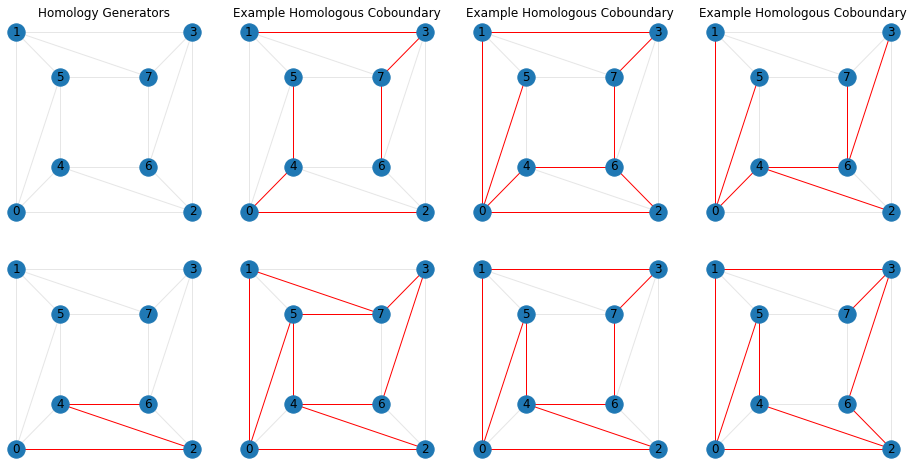

In [74]:
annulus_points = np.array([
    [0, 0],
    [0, 4],
    [4, 0],
    [4, 4],
    [1, 1],
    [1, 3],
    [3, 1],
    [3, 3]
])

annulus_edges = [
    (0, 1),
    (1, 3),
    (0, 2),
    (2, 3),
    (4, 5),
    (4, 6),
    (5, 7),
    (6, 7),
    (0, 4),
    (0, 5),
    (1, 5),
    (1, 7),
    (2, 4),
    (2, 6),
    (3, 6),
    (3, 7)
]

simplices = [
    (0, 4, 5),
    (0, 2, 4),
    (2, 4, 6),
    (2, 3, 6),
    (0, 1, 5),
    (1, 5, 7),
    (1, 3, 7),
    (3, 6, 7)

]
cplx = SimplicialComplex([faces(annulus_edges), annulus_edges, simplices], annulus_points, CyclicGroup(2))
cplx.draw_cohomology_generators()

729it [00:00, 49018.05it/s]
2187it [00:00, 132352.33it/s]


1: 0,0,0,0,0,0,0
   1: 0,0,2,0,0,2,2
   1: 1,0,1,0,2,2,0
   1: 2,0,1,2,1,2,1
1: 1,0,0,0,0,0,0
   1: 2,1,2,2,1,0,0
   1: 0,2,1,1,2,0,0
   1: 1,0,2,1,0,0,0
1: 0,0,0,0,1,0,0
   1: 2,0,0,2,0,2,0
   1: 2,0,0,0,2,2,1
   1: 0,2,1,2,2,2,0


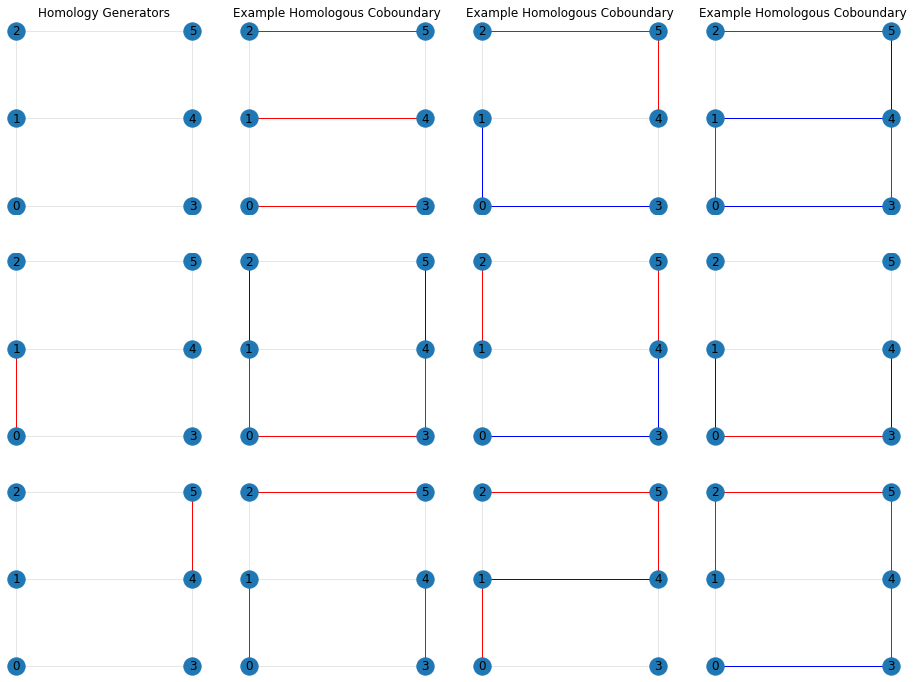

In [75]:
double_annulus_points = np.array([
    [0, 0],
    [0, 1],
    [0, 2],
    [1, 0],
    [1, 1],
    [1, 2]
])

double_annulus_edges = [
    (0, 1),
    (1, 2),
    (0, 3),
    (3, 4),
    (4, 5),
    (2, 5),
    (1, 4)
]

cplx = SimplicialComplex([faces(double_annulus_edges), double_annulus_edges], double_annulus_points, CyclicGroup(3))
cplx.draw_cohomology_generators()

16it [00:00, 41145.84it/s]
64it [00:00, 37738.71it/s]
16it [00:00, 77314.36it/s]

1: 0,0,0,0,0,0
   1: 0,0,0,0,0,0
   1: 1,0,1,1,0,1
   1: 0,1,0,1,0,1


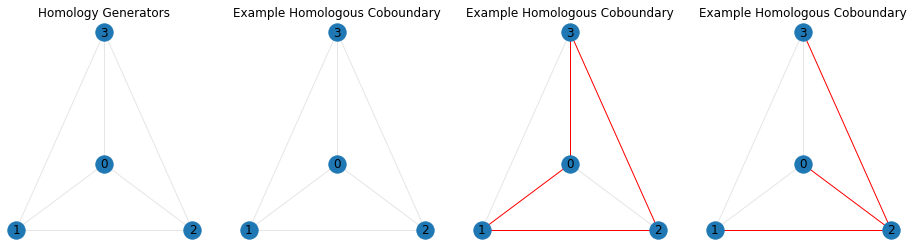

In [91]:
tetra_points = np.array([
    [0, 0],
    [-2, -1],
    [2, -1],
    [0, 2]
])

tetra_edges = [
    (0, 1),
    (0, 2),
    (0, 3),
    (1, 2),
    (1, 3),
    (2, 3)
]

tetra_simplices = [
    (0,1,2),
    (0,1,3),
    (0,2,3),
    (1,2,3),
]

cplx = SimplicialComplex([faces(tetra_edges), tetra_edges, tetra_simplices], tetra_points, CyclicGroup(2))
cplx.draw_cohomology_generators()

In [100]:
print("H^2 generators:")
"; ".join(str(c) for c in cplx.cochain_complex.cochain_groups[2].cohomology_groups.keys())

H^2 generators:


'2: 0,0,0,0; 2: 0,1,0,0'